# Role of time-aware and similarity-aware splits

This notebook analyzes the differences between the proposed split (either time-aware or similarity-aware) and the random split. The results are shown and described in the accompanying paper.

In [1]:
import sys

sys.path.insert(0, "../..")

import copy
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from utils import compute_predictions, make_radar_plot2, mean

from wildlife_datasets.datasets import WildlifeReID10k
from wildlife_datasets.metrics import BAKS, BAUS
from wildlife_datasets.splits import BalancedSplit

In [2]:
root_data = "/data/wildlife_datasets/data/WildlifeReID10k"
root_images = os.path.join(root_data, "images")
root_features = "features_dino"
root_clusters = "clusters"

d = WildlifeReID10k(root_data)
d.df["date"] = pd.to_datetime(d.df["date"])

In [3]:
splitter = BalancedSplit(seed=666)

# Add random split
idx_test = []
for name, df_dataset in d.df.groupby("dataset"):
    df_train = df_dataset[df_dataset["split"] == "train"]
    df_test = df_dataset[df_dataset["split"] == "test"]
    _, idx = splitter.resplit_random(df_dataset, df_train.index, df_test.index)
    idx_test = idx_test + list(idx)
d.df["split_random"] = "train"
d.df.loc[idx_test, "split_random"] = "test"

# Check if the number of individuals is the same for splits
for _, df_identity in d.df.groupby("identity"):
    sum1 = sum(df_identity["split"] == "test")
    sum2 = sum(df_identity["split_random"] == "test")
    sum3 = sum(df_identity["split"] == "train")
    sum4 = sum(df_identity["split_random"] == "train")
    if sum1 != sum2 or sum3 != sum4:
        raise Exception("Number of images is wrong")

In [4]:
roots = ["features_mega", "features_miew"]
cols = ["split", "split_random"]
file_name = "results/results.pickle"

step = 0.01
ts = [-np.inf] + list(np.arange(0, 1 + step / 10, step)) + [np.inf]
new_individual = "new_individual"

baks = {root: {col: {t: {} for t in ts} for col in cols} for root in roots}
baus = {root: {col: {t: {} for t in ts} for col in cols} for root in roots}
if not os.path.exists(file_name):
    for root in roots:
        for col in cols:
            print(root, col)
            result = {}
            for name, df_dataset in d.df.groupby("dataset"):
                features = np.load(f"{root}/features_{name}.npy")

                idx_train = np.where(df_dataset[col] == "train")[0]
                idx_test = np.where(df_dataset[col] == "test")[0]

                idx_true, idx_pred, similarity = compute_predictions(
                    features[idx_test], features[idx_train], return_score=True
                )
                idx_true = idx_test[idx_true]
                idx_pred = idx_train[idx_pred]
                idx_pred = idx_pred[:, 0]
                similarity = similarity[:, 0]

                y_true = df_dataset["identity"].iloc[idx_true]
                y_pred_closed = df_dataset["identity"].iloc[idx_pred]

                identity_test_only = list(
                    set(df_dataset["identity"].iloc[idx_test]) - set(df_dataset["identity"].iloc[idx_train])
                )

                for t in ts:
                    y_pred = copy.copy(y_pred_closed)
                    with np.errstate(invalid="ignore"):
                        y_pred[similarity < t] = new_individual
                    baks[root][col][t][name] = BAKS(y_true, y_pred, identity_test_only)
                    baus[root][col][t][name] = BAUS(y_true, y_pred, identity_test_only, new_individual)
    with open(file_name, "wb") as handle:
        pickle.dump([baks, baus], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(file_name, "rb") as handle:
        baks, baus = pickle.load(handle)

In [5]:
names_trained = [
    "AAUZebraFish",
    "AerialCattle2017",
    "ATRW",
    "BelugaID",
    "BirdIndividualID",
    "CTai",
    "CZoo",
    "Cows2021",
    "FriesianCattle2015",
    "FriesianCattle2017",
    "GiraffeZebraID",
    "Giraffes",
    "HyenaID2022",
    "IPanda50",
    "LeopardID2022",
    "NDD20",
    "NyalaData",
    "OpenCows2020",
    "SealID",
    "SeaTurtleID2022",
    "SMALST",
    "StripeSpotter",
    "WhaleSharkID",
    "ZindiTurtleRecall",
]
names_time_split = [
    "BelugaID",
    "BirdIndividualID",
    "CowDataset",
    "Cows2021",
    "GiraffeZebraID",
    "Giraffes",
    "MultiCamCows2024",
    "SeaStarReID2023",
    "SeaTurtleID2022",
]
names_non_trained = list(set(d.df["dataset"].unique()) - set(names_trained))
names_similarity_split = list(set(d.df["dataset"].unique()) - set(names_time_split))

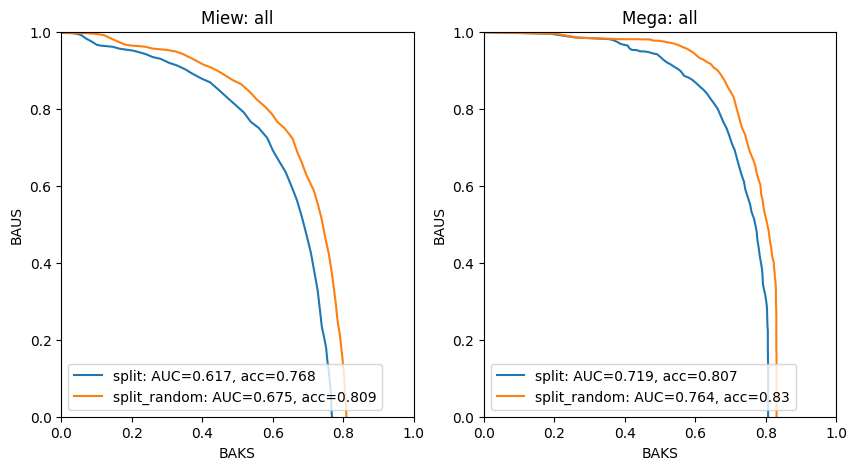

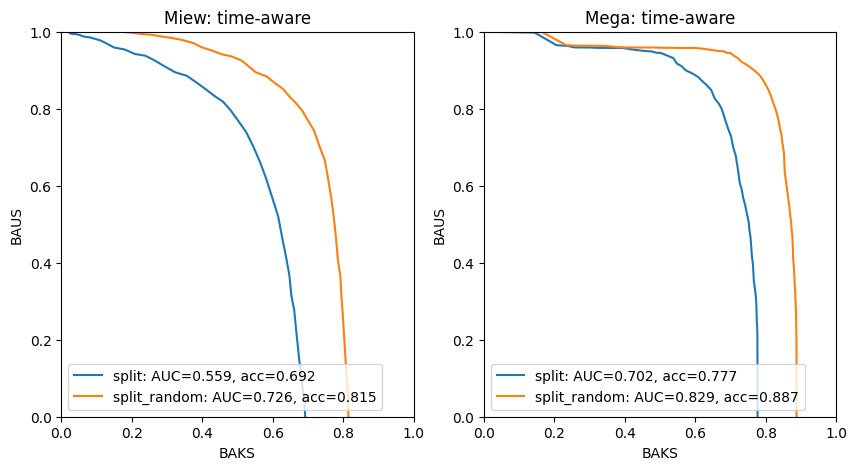

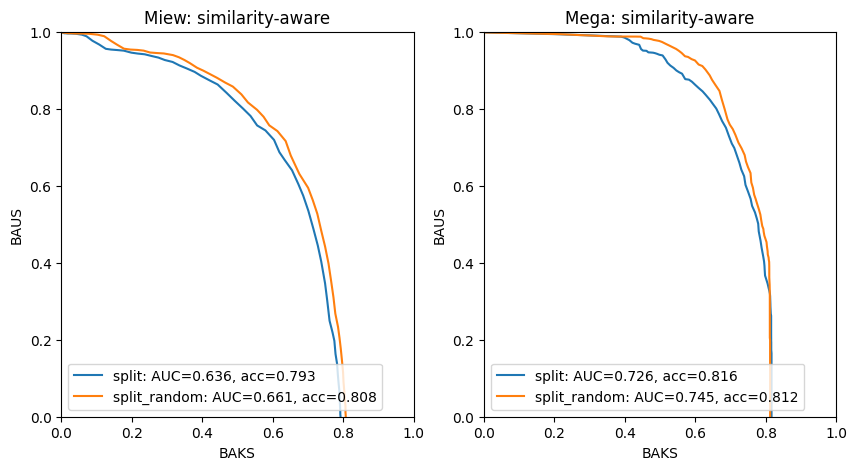

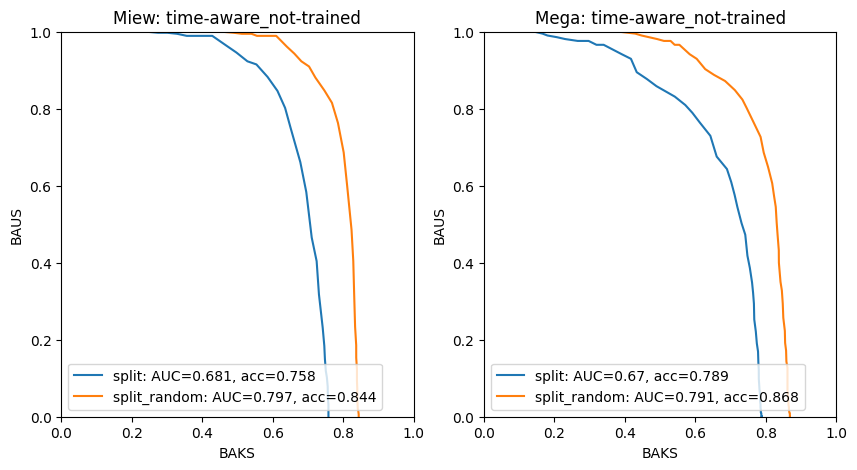

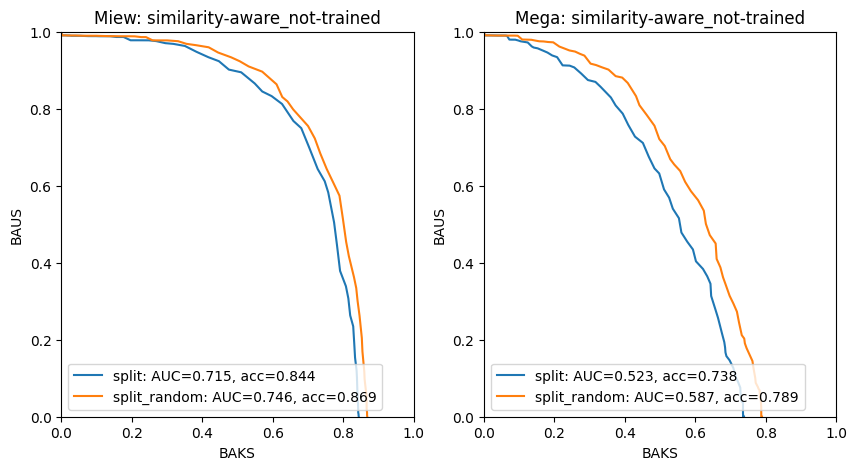

In [6]:
idx = names_time_split
idx = names_trained

idx_all = [
    None,
    names_time_split,
    names_similarity_split,
    list(set(names_non_trained).intersection(names_time_split)),
    list(set(names_non_trained).intersection(names_similarity_split)),
]
titles = [
    "all",
    "time-aware",
    "similarity-aware",
    "time-aware_not-trained",
    "similarity-aware_not-trained",
]

for i, (idx, title) in enumerate(zip(idx_all, titles)):
    results = {}
    legend = []
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for col in cols:
        data1 = [mean(baks["features_miew"][col][t], idx=idx) for t in ts]
        data2 = [mean(baus["features_miew"][col][t], idx=idx) for t in ts]
        results[f"MiewID {col} BAKS"] = data1
        results[f"MiewID {col} BAUS"] = data2
        ax[0].plot(data1, data2, label=f"{col}: AUC={np.round(auc(data1, data2), 3)}, acc={np.round(data1[0], 3)}")
        data1 = [mean(baks["features_mega"][col][t], idx=idx) for t in ts]
        data2 = [mean(baus["features_mega"][col][t], idx=idx) for t in ts]
        ax[1].plot(data1, data2, label=f"{col}: AUC={np.round(auc(data1, data2), 3)}, acc={np.round(data1[0], 3)}")
        results[f"MegaDescriptor {col} BAKS"] = data1
        results[f"MegaDescriptor {col} BAUS"] = data2
    for j in range(2):
        ax[j].set_xlim([0, 1])
        ax[j].set_ylim([0, 1])
        ax[j].set_xlabel("BAKS")
        ax[j].set_ylabel("BAUS")
        ax[j].legend(loc="lower left")
    ax[0].set_title(f"Miew: {title}")
    ax[1].set_title(f"Mega: {title}")
    pd.DataFrame(results).to_csv(f"results/{title}.csv", index=False)

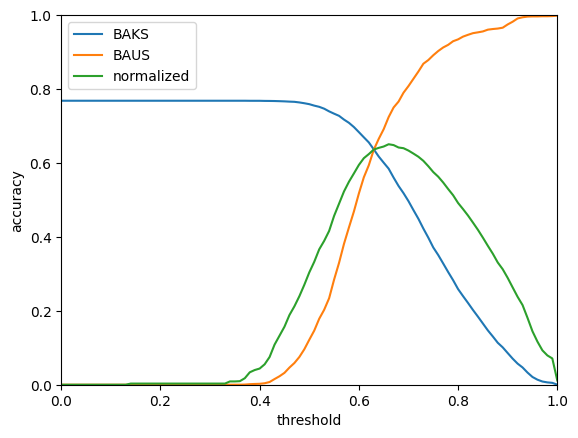

In [7]:
data_baks = np.array([mean(baks["features_miew"]["split"][t]) for t in ts])
data_baus = np.array([mean(baus["features_miew"]["split"][t]) for t in ts])
data_normalized = np.sqrt(data_baks * data_baus)

plt.plot(ts, data_baks, label="BAKS")
plt.plot(ts, data_baus, label="BAUS")
plt.plot(ts, data_normalized, label="normalized")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("threshold")
plt.ylabel("accuracy")
plt.legend()
pd.DataFrame(
    {
        "t": ts[1:-1],
        "BAKS": data_baks[1:-1],
        "BAUS": data_baus[1:-1],
        "normalized": data_normalized[1:-1],
    }
).to_csv("results/normalized.csv", index=False)

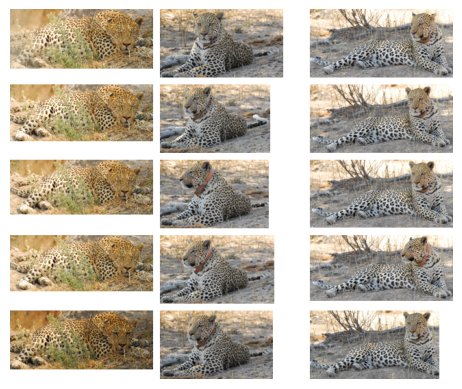

In [8]:
idx = []
df_dataset = d.df[d.df["dataset"] == "LeopardID2022"]
for _, df_cluster in df_dataset.groupby("cluster_id"):
    if len(df_cluster) >= 5:
        idx = idx + list(df_cluster.index)[:5]
        if len(idx) > 10:
            break
idx = np.reshape(idx, (-1, 5))
idx = idx.T.flatten()
d.plot_grid(idx=idx, n_rows=5, n_cols=3, background_color=(255, 255, 255));

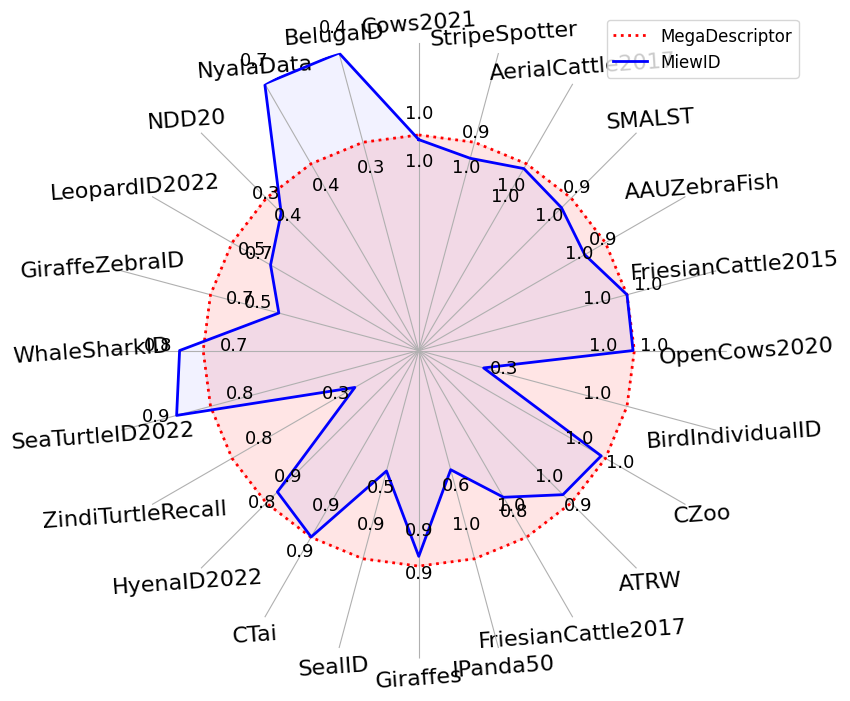

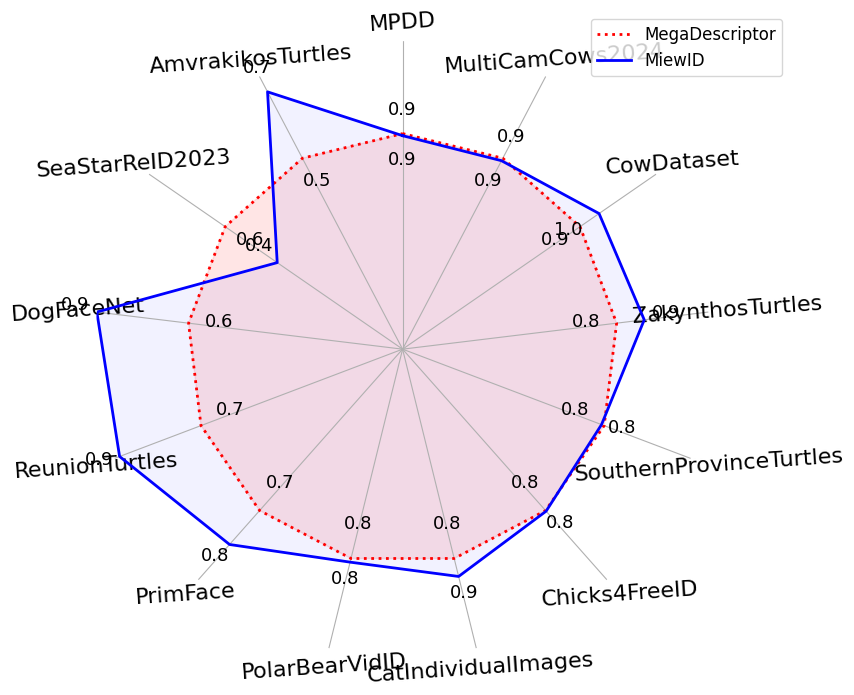

In [9]:
results_closed = pd.DataFrame(
    {
        "MiewID": baks["features_miew"]["split"][np.min(ts)],
        "MegaDescriptor": baks["features_mega"]["split"][np.min(ts)],
    }
)
results_closed = results_closed.sort_values("MegaDescriptor", ascending=False)
color = {"MiewID": "blue", "MegaDescriptor": "red"}
cols = ["MegaDescriptor", "MiewID"]

idx = results_closed.index.isin(names_trained)
make_radar_plot2(results_closed[idx], color, cols, figsize=(8, 8))
idx = ~results_closed.index.isin(names_trained)
make_radar_plot2(results_closed[idx], color, cols, figsize=(8, 8))